In [3]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Desktop/BDAI2/Satellite_Super_Resulotion0")
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

✔ Model loaded (best PSNR = 28.28)


/tmp/ipykernel_36608/1257418977.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


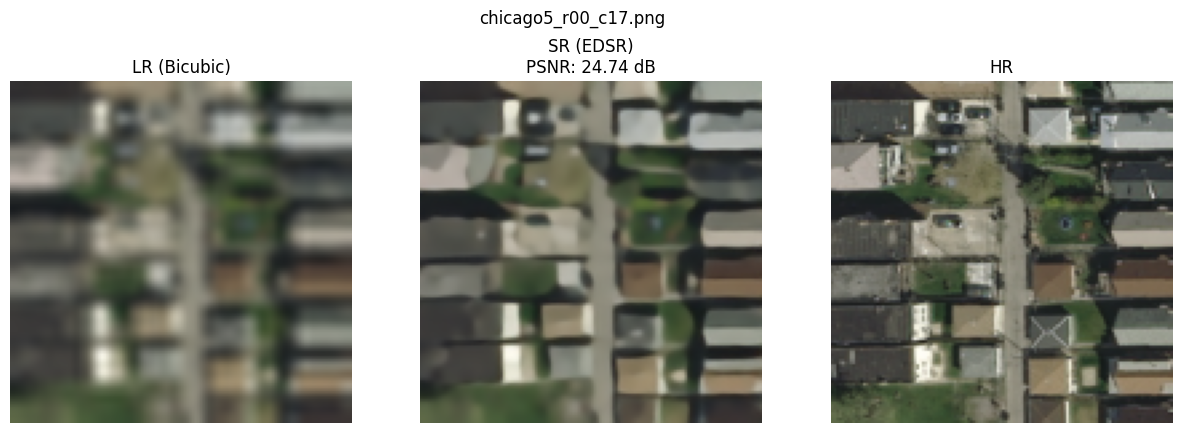

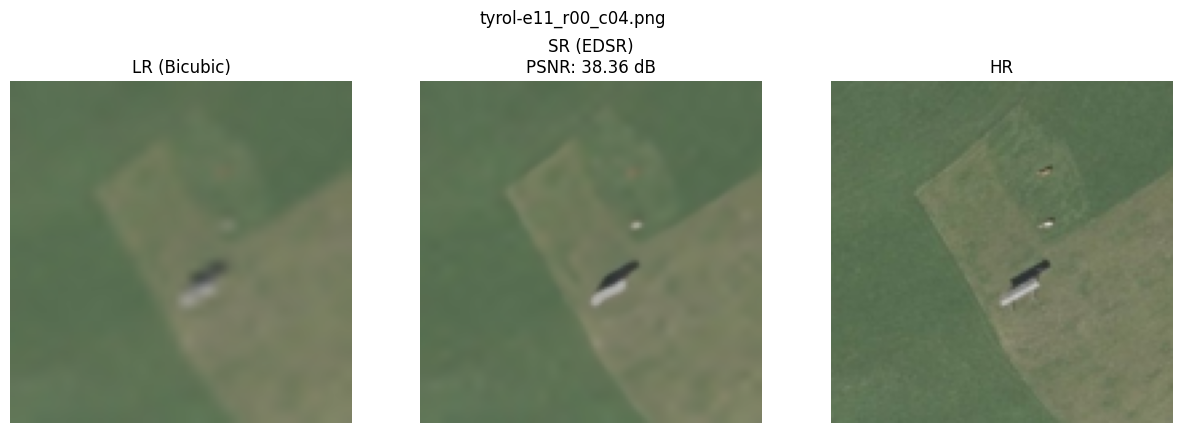

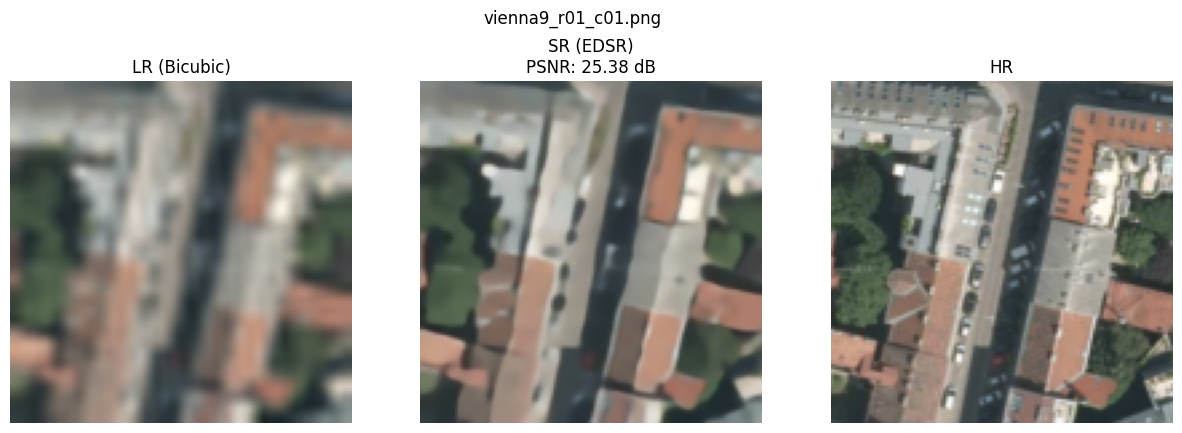

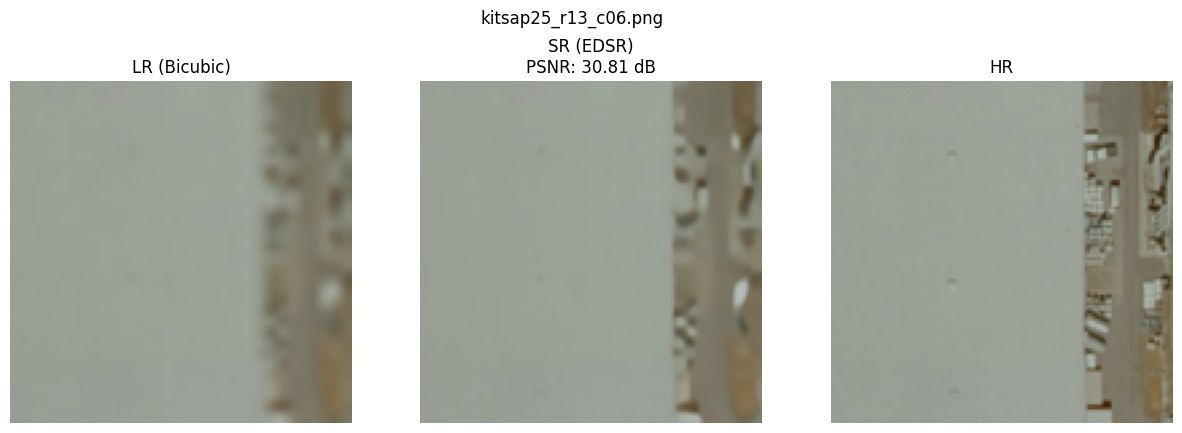

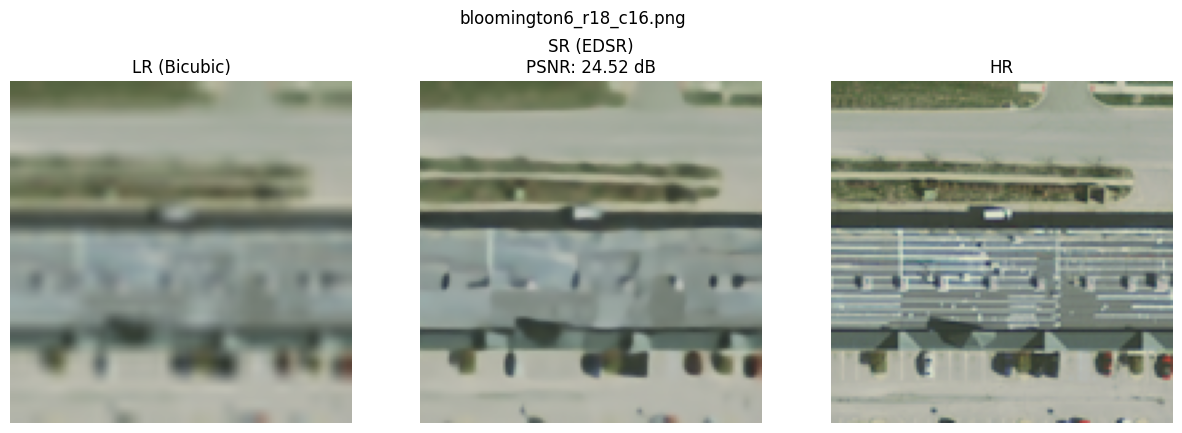

PSNR per image:
chicago5_r00_c17.png : 24.74 dB
tyrol-e11_r00_c04.png : 38.36 dB
vienna9_r01_c01.png : 25.38 dB
kitsap25_r13_c06.png : 30.81 dB
bloomington6_r18_c16.png : 24.52 dB
-----------------------------------
Average PSNR : 28.76 dB


In [ ]:
from src.utils.models_architecture import EDSR

# ================== CONFIG ==================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LR_DIR = "data/preprocessed/test/LR"
HR_DIR = "data/preprocessed/test/HR"
BEST_MODEL_PATH = "MODEL_TEST/best_EDSR.pth"   # adapte si besoin
N_SAMPLES = 5
SCALE = 4

# ================== TRANSFORMS ==================
to_tensor = transforms.ToTensor()

# ================== PSNR ==================
def psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# ================== LOAD MODEL ==================
model = EDSR(scale_factor=SCALE).to(DEVICE)
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

print(f"✔ Model loaded (best PSNR = {ckpt['best_psnr']:.2f})")

# ================== RANDOM IMAGES ==================
lr_images = sorted(os.listdir(LR_DIR))
selected_imgs = random.sample(lr_images, N_SAMPLES)

psnr_values = []

# ================== INFERENCE ==================
with torch.no_grad():
    for img_name in selected_imgs:
        # Load images
        lr_img = Image.open(os.path.join(LR_DIR, img_name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, img_name)).convert("RGB")

        lr = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        hr = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # SR inference
        sr = model(lr)
        sr = torch.clamp(sr, 0.0, 1.0)

        # PSNR
        val_psnr = psnr(sr, hr).item()
        psnr_values.append(val_psnr)

        # ================== DISPLAY ==================
        lr_up = F.interpolate(lr, scale_factor=SCALE, mode="bicubic", align_corners=False)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(lr_up.squeeze().permute(1, 2, 0).cpu())
        ax[0].set_title("LR (Bicubic)")
        ax[1].imshow(sr.squeeze().permute(1, 2, 0).cpu())
        ax[1].set_title(f"SR (EDSR)\nPSNR: {val_psnr:.2f} dB")
        ax[2].imshow(hr.squeeze().permute(1, 2, 0).cpu())
        ax[2].set_title("HR")

        for a in ax:
            a.axis("off")

        plt.suptitle(img_name)
        plt.show()

# ================== FINAL REPORT ==================
print("===================================")
print("PSNR per image:")
for name, val in zip(selected_imgs, psnr_values):
    print(f"{name} : {val:.2f} dB")

print("-----------------------------------")
print(f"Average PSNR : {np.mean(psnr_values):.2f} dB")
print("===================================")


/tmp/ipykernel_36608/1578917641.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


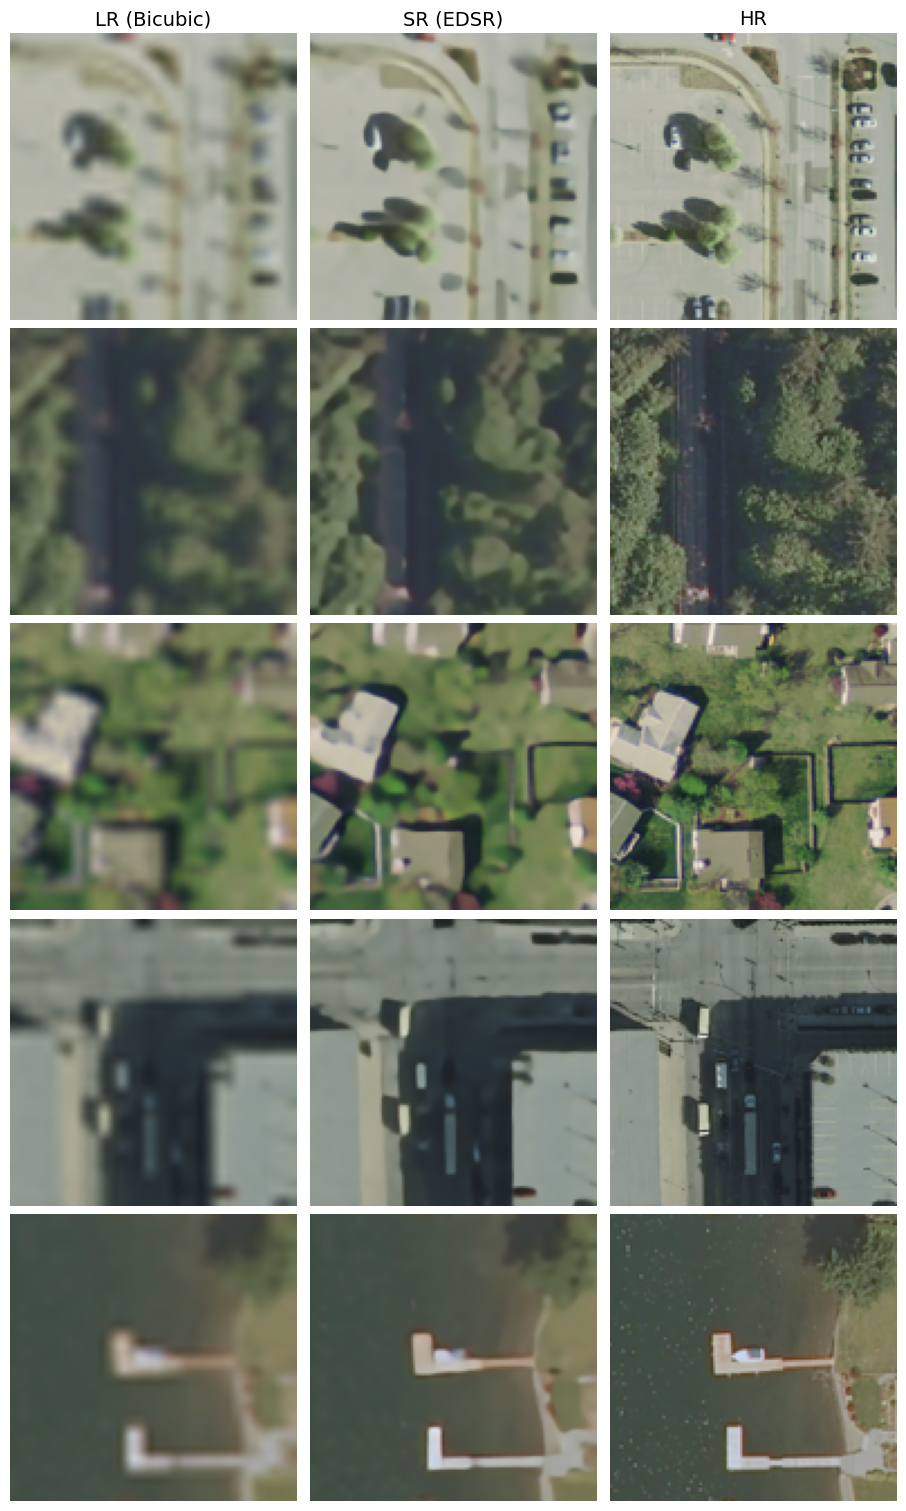

In [25]:
import os
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ================= CONFIG =================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LR_DIR = "data/preprocessed/test/LR"
HR_DIR = "data/preprocessed/test/HR"

BEST_MODEL_PATH = "MODEL_TEST/best_EDSR.pth"   # adapte si besoin

N_SAMPLES = 5
SCALE = 4

to_tensor = transforms.ToTensor()

# ================= LOAD MODEL =================
model = EDSR(scale_factor=SCALE).to(DEVICE)
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

# ================= SELECT IMAGES =================
lr_files = sorted(os.listdir(LR_DIR))
selected = random.sample(lr_files, N_SAMPLES)

# ================= FIGURE =================
fig, axes = plt.subplots(
    nrows=N_SAMPLES,
    ncols=3,
    figsize=(9, 3 * N_SAMPLES),
    constrained_layout=True
)

# Column titles
titles = ["LR (Bicubic)", "SR (EDSR)", "HR"]
for col, title in enumerate(titles):
    axes[0, col].set_title(title, fontsize=14)

# ================= INFERENCE & PLOT =================
with torch.no_grad():
    for row, img_name in enumerate(selected):
        # Load images
        lr_img = Image.open(os.path.join(LR_DIR, img_name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, img_name)).convert("RGB")

        lr = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        hr = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # SR
        sr = model(lr)
        sr = torch.clamp(sr, 0, 1)

        # Bicubic upscale
        lr_up = F.interpolate(
            lr,
            scale_factor=SCALE,
            mode="bicubic",
            align_corners=False
        )

        # Convert to display format
        lr_up = lr_up.squeeze().permute(1, 2, 0).cpu()
        sr = sr.squeeze().permute(1, 2, 0).cpu()
        hr = hr.squeeze().permute(1, 2, 0).cpu()

        # Plot
        axes[row, 0].imshow(lr_up)
        axes[row, 1].imshow(sr)
        axes[row, 2].imshow(hr)

        for col in range(3):
            axes[row, col].axis("off")

plt.show()



/tmp/ipykernel_36608/151904127.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


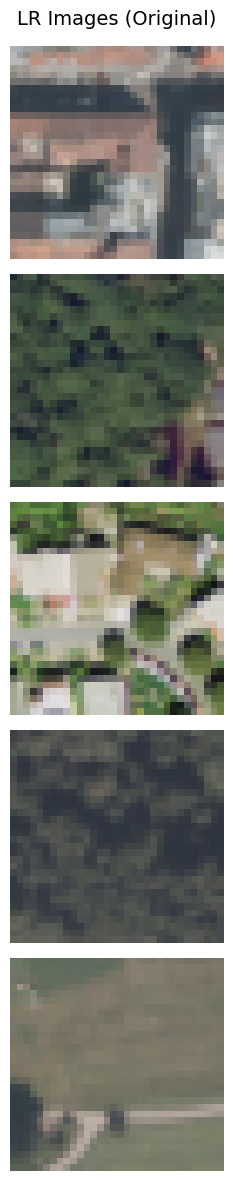

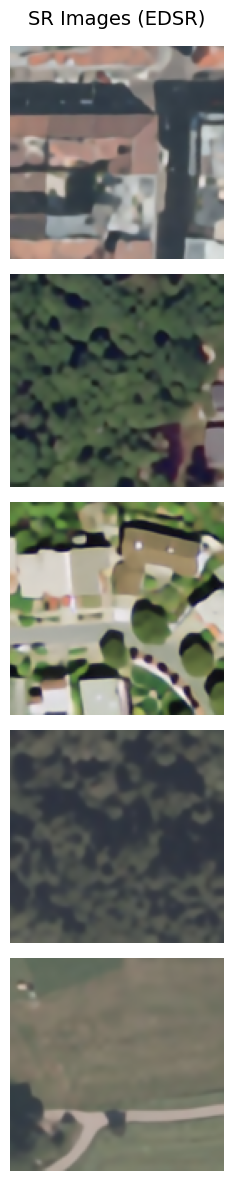

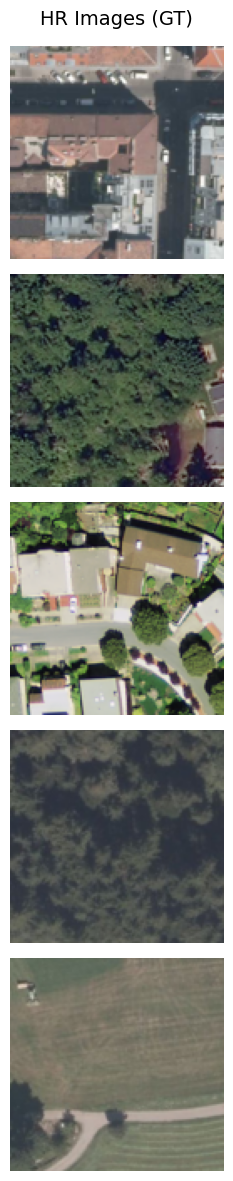

In [27]:
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ================= CONFIG =================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR_DIR = "data/preprocessed/test/LR"
HR_DIR = "data/preprocessed/test/HR"
BEST_MODEL_PATH = "MODEL_TEST/best_EDSR.pth"
N_SAMPLES = 5
SCALE = 4

to_tensor = transforms.ToTensor()

# ================= LOAD MODEL =================
model = EDSR(scale_factor=SCALE).to(DEVICE)
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

# ================= SELECT RANDOM IMAGES =================
img_names = sorted(os.listdir(LR_DIR))
selected_imgs = random.sample(img_names, N_SAMPLES)

lr_imgs, sr_imgs, hr_imgs = [], [], []

with torch.no_grad():
    for name in selected_imgs:
        lr_img = Image.open(os.path.join(LR_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        lr = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        sr = torch.clamp(model(lr), 0.0, 1.0)

        lr_imgs.append(lr_img)
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)

# ================= PLOTTING FUNCTION =================
def plot_column(images, title):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))

    for i, ax in enumerate(axes):
        if torch.is_tensor(images[i]):
            ax.imshow(images[i])
        else:
            ax.imshow(images[i])

        ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# ================= PLOTS =================
plot_column(lr_imgs, "LR Images (Original)")
plot_column(sr_imgs, "SR Images (EDSR)")
plot_column(hr_imgs, "HR Images (GT)")


✔ Model loaded (best PSNR = 28.28)


/tmp/ipykernel_70259/1266138169.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


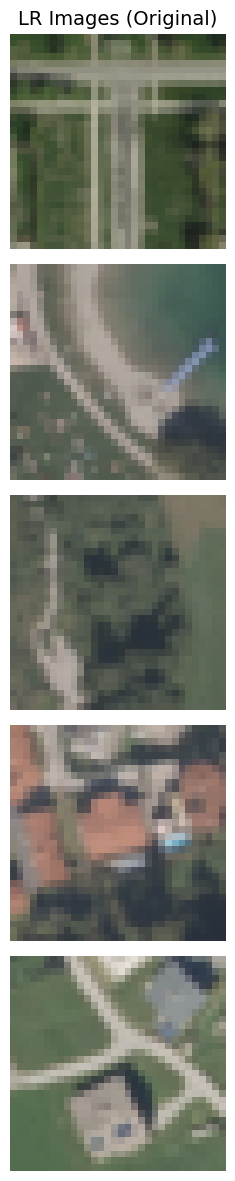

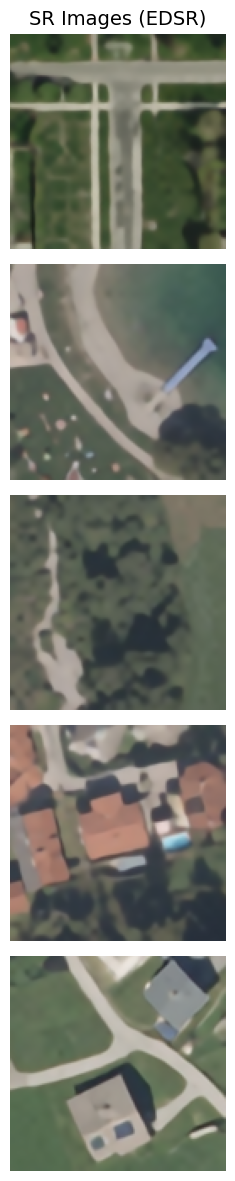

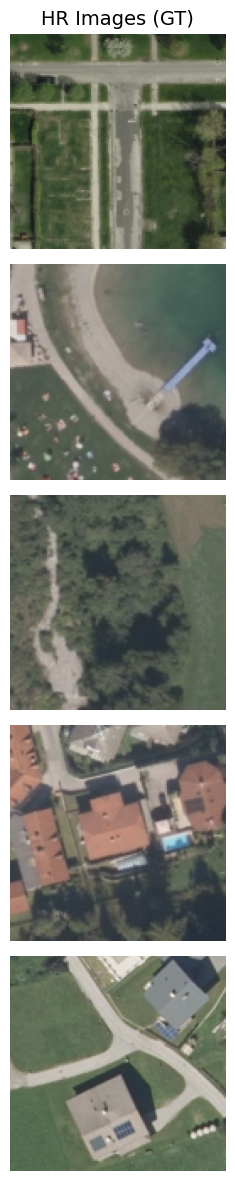

In [5]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from src.utils.models_architecture import EDSR
# ================= CONFIG =================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"
BEST_MODEL_PATH = "MODEL_TEST/best_EDSR.pth"
SCALE = 4

to_tensor = transforms.ToTensor()

# ================= LOAD MODEL =================
model = EDSR(scale_factor=SCALE).to(DEVICE)
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

print(f"✔ Model loaded (best PSNR = {ckpt['best_psnr']:.2f})")

# ================= LOAD IMAGES =================
img_names = sorted(os.listdir(TEST_DIR))

lr_imgs, sr_imgs, hr_imgs = [], [], []

with torch.no_grad():
    for name in img_names:
        # LR from data_test
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")

        # HR from HR folder (same filename)
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        lr = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        sr = torch.clamp(model(lr), 0.0, 1.0)

        lr_imgs.append(lr_img)
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)

# ================= PLOT FUNCTION =================
def plot_column(images, title):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.show()

# ================= PLOTS =================
plot_column(lr_imgs, "LR Images (Original)")
plot_column(sr_imgs, "SR Images (EDSR)")
plot_column(hr_imgs, "HR Images (GT)")
